In [1]:
import functools
import numpy as np
import pandas as pd
import random
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from data_provider import get_data
from simulation import get_match_feature_vector, post_match_results, post_simulation
from data_provider import append_player_data

In [2]:
dataset = get_data(suffle=True)
dataset.tail()

,id,date,home_team,away_team,home_score,away_score,tournament,city,country,year,...,away_Long_Shots,away_Aggression,away_Penalties,away_Marking,away_Standing_Tackle,away_GK_Diving,away_GK_Handling,away_GK_Kicking,away_GK_Positioning,away_GK_Reflexes
39003,39004.0,2018-06-04 00:00:00,Italy,Netherlands,1.0,1.0,Friendly,Turin,Italy,2018,...,79.100000,80.8,84.333333,83.000000,83.4,79.0,80.0,75.5,80.0,80.0
39004,39005.0,2018-06-04 00:00:00,Serbia,Chile,0.0,1.0,Friendly,Graz,Austria,2018,...,79.500000,85.0,82.000000,76.333333,80.8,78.0,77.0,78.0,76.5,77.0
39005,39006.0,2018-06-04 00:00:00,Slovakia,Morocco,1.0,2.0,Friendly,Geneva,Switzerland,2018,...,75.700000,80.8,79.000000,81.333333,78.4,44.0,47.0,44.5,45.5,44.0
39006,39007.0,2018-06-04 00:00:00,Armenia,Moldova,0.0,0.0,Friendly,Kematen,Austria,2018,...,42.975000,72.2,61.333333,73.333333,73.6,13.0,15.0,14.0,13.5,12.5
39007,39008.0,2018-06-04 00:00:00,India,Kenya,3.0,0.0,Friendly,Mumbai,India,2018,...,46.671429,73.2,57.666667,68.000000,63.2,13.0,14.5,15.0,13.5,13.5


In [3]:
print("Dataset length", dataset.shape[0])
dataset = dataset.dropna()
print("Dataset complete cases length", dataset.shape[0])

Dataset length 39008
Dataset complete cases length 6676


In [4]:
dataset.columns

Index(['id', 'date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'year', 'simulation', 'home_elo',
       'away_elo', 'goal_diff_with_away', 'home_goals_with_away',
       'away_goals_with_home', 'home_goal_mean', 'away_goal_mean',
       'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'home_GK_Div

In [5]:
def calculate_relative_features(dataset):
    dataset["home_win"] = np.sign(dataset["home_score"] - dataset["away_score"])
    dataset["elo_diff"] = dataset["home_elo"] - dataset["away_elo"]
    dataset["rating_diff"] = dataset["home_overall_rating_avg"] - dataset["away_overall_rating_avg"]
    dataset["potential_diff"] = dataset["home_potential_avg"] - dataset["away_potential_avg"]
    dataset["height_diff"] = dataset["home_height"] - dataset["away_height"]
    dataset["weight_diff"] = dataset["home_weight"] - dataset["away_weight"]
    dataset["age_diff"] = dataset["home_age"] - dataset["away_age"]
    dataset["weak_foot_diff"] = dataset["home_weak_foot"] - dataset["away_weak_foot"]
    dataset["internationl_repuatiotion_diff"] = dataset["home_international_reputation"] - dataset["away_international_reputation"]
    dataset["crossing_diff"] = dataset["home_Crossing"] - dataset["away_Crossing"]
    dataset["finishing_diff"] = dataset["home_Finishing"] - dataset["away_Finishing"]
    dataset["heading_accuracy_diff"] = dataset["home_Heading_Accuracy"] - dataset["away_Heading_Accuracy"]
    dataset["short_passing_diff"] = dataset["home_Short_Passing"] - dataset["away_Short_Passing"]
    dataset["dribbling_diff"] = dataset["home_Dribbling"] - dataset["away_Dribbling"]
    dataset["fk_accuracy_diff"] = dataset["home_FK_Accuracy"] - dataset["away_FK_Accuracy"]
    dataset["long_passing_diff"] = dataset["home_Long_Passing"] - dataset["away_Long_Passing"]
    dataset["ball_control_diff"] = dataset["home_Ball_Control"] - dataset["away_Ball_Control"]
    dataset["acceleration_diff"] = dataset["home_Acceleration"] - dataset["away_Acceleration"]
    dataset["sprint_speed_diff"] = dataset["home_Sprint_Speed"] - dataset["away_Sprint_Speed"]
    dataset["reactions_diff"] = dataset["home_Reactions"] - dataset["away_Reactions"]
    dataset["shot_power_diff"] = dataset["home_Shot_Power"] - dataset["away_Shot_Power"]
    dataset["stamina_diff"] = dataset["home_Stamina"] - dataset["away_Stamina"]
    dataset["strength_diff"] = dataset["home_Strength"] - dataset["away_Strength"]
    dataset["long_shots_diff"] = dataset["home_Long_Shots"] - dataset["away_Long_Shots"]
    dataset["aggression_diff"] = dataset["home_Aggression"] - dataset["away_Aggression"]
    dataset["penalties_diff"] = dataset["home_Penalties"] - dataset["away_Penalties"]
    dataset["marking_diff"] = dataset["home_Marking"] - dataset["away_Marking"]
    dataset["standing_tackle_diff"] = dataset["home_Standing_Tackle"] - dataset["away_Standing_Tackle"]
    dataset["gk_diving_diff"] = dataset["home_GK_Diving"] - dataset["away_GK_Diving"]
    dataset["gk_handling_diff"] = dataset["home_GK_Handling"] - dataset["away_GK_Handling"]
    dataset["gk_kicking_diff"] = dataset["home_GK_Kicking"] - dataset["away_GK_Kicking"]
    dataset["gk_reflexes_diff"] = dataset["home_GK_Reflexes"] - dataset["away_GK_Reflexes"]
    #dataset["home_game"] = np.where(dataset['home_team']==dataset["country"], 1, 0)
    return dataset

dataset = calculate_relative_features(dataset)

In [6]:
feature_columns = ['home_elo',
       'away_elo', 'goal_diff_with_away', 'home_goals_with_away',
       'away_goals_with_home', 'home_goal_mean', 'away_goal_mean',
       'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'home_GK_Diving', 'home_GK_Handling', 'home_GK_Kicking',
       'home_GK_Positioning', 'home_GK_Reflexes', 'away_overall_rating_max',
       'away_overall_rating_min', 'away_overall_rating_avg',
       'away_potential_max', 'away_potential_min', 'away_potential_avg',
       'away_height', 'away_weight', 'away_age', 'away_top_11_age',
       'away_weak_foot', 'away_international_reputation', 'away_Crossing',
       'away_Finishing', 'away_Heading_Accuracy', 'away_Short_Passing',
       'away_Dribbling', 'away_FK_Accuracy', 'away_Long_Passing',
       'away_Ball_Control', 'away_Acceleration', 'away_Sprint_Speed',
       'away_Reactions', 'away_Shot_Power', 'away_Stamina', 'away_Strength',
       'away_Long_Shots', 'away_Aggression', 'away_Penalties', 'away_Marking',
       'away_Standing_Tackle', 'away_GK_Diving', 'away_GK_Handling',
       'away_GK_Kicking', 'away_GK_Positioning', 'away_GK_Reflexes']

In [7]:
feature_columns = ["elo_diff", "rating_diff", "potential_diff",
                   "height_diff", "weight_diff", "age_diff", "weak_foot_diff",
                   "internationl_repuatiotion_diff", "crossing_diff", "finishing_diff", "heading_accuracy_diff",
                   "short_passing_diff", "dribbling_diff", "fk_accuracy_diff", "long_passing_diff",
                   'ball_control_diff', 'acceleration_diff', 'sprint_speed_diff', "reactions_diff",
                   'shot_power_diff', 'stamina_diff', 'strength_diff', 'long_shots_diff',
                   "aggression_diff", "penalties_diff", "marking_diff", "standing_tackle_diff",
                   "away_goal_mean", "away_goals_with_home", "goal_diff_with_away", "home_goal_mean",
                   "home_goals_with_away", "gk_diving_diff", "gk_handling_diff", "gk_kicking_diff", "gk_reflexes_diff"]

wtl_col = "home_win"

In [8]:
no_friendly_or_wc = dataset[(dataset["tournament"] != "Friendly") & (dataset["tournament"] != "FIFA World Cup")]
print("No friendly or WC games length: ", no_friendly_or_wc.shape[0])

X = no_friendly_or_wc[feature_columns]
y = no_friendly_or_wc[wtl_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("No friendly games train set length: ", X_train.shape[0])

friendly_games = dataset[dataset["tournament"] == "Friendly"]
print("Friendly games length: ", friendly_games.shape[0])
X_friendly = friendly_games[feature_columns]
y_friendly = friendly_games[wtl_col]

X_train = pd.concat([X_train, X_friendly])
y_train = pd.concat([y_train, y_friendly])

wc_games = dataset[dataset["tournament"] == "FIFA World Cup"]
print("WC games length: ", wc_games.shape[0])
X_wc = wc_games[feature_columns]
y_wc = wc_games[wtl_col]
X_test = pd.concat([X_test, X_wc])
y_test = pd.concat([y_test, y_wc])

print("Whole train set length: ", X_train.shape[0])
print("Whole test set length: ", X_test.shape[0])
print("Train set width: ", X_train.shape[1])

No friendly or WC games length:  3788
No friendly games train set length:  2841
Friendly games length:  2760
WC games length:  128
Whole train set length:  5601
Whole test set length:  1075
Train set width:  36


In [9]:
no_friendly_or_wc

,id,date,home_team,away_team,home_score,away_score,tournament,city,country,year,...,strength_diff,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
28531,28532.0,2007-01-07 00:00:00,Bermuda,Haiti,0.0,2.0,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,2007,...,-11.475000,-2.700000,-16.650,-19.066667,-25.200000,-11.350000,0.5,-8.5,-31.5,-7.5
28535,28536.0,2007-01-09 00:00:00,Bermuda,Haiti,0.0,3.0,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,2007,...,-11.475000,-2.700000,-16.650,-19.066667,-25.200000,-11.350000,0.5,-8.5,-31.5,-7.5
28541,28542.0,2007-01-12 00:00:00,Trinidad and Tobago,Barbados,1.0,1.0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,10.000000,2.800000,17.800,14.333333,44.166667,38.400000,53.5,52.0,29.5,57.0
28550,28551.0,2007-01-15 00:00:00,Haiti,Barbados,2.0,0.0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,-0.225000,-5.400000,3.150,4.666667,22.500000,10.450000,-4.5,2.5,21.5,0.5
28560,28561.0,2007-01-17 00:00:00,Haiti,Trinidad and Tobago,1.0,3.0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,-10.225000,-8.200000,-14.650,-9.666667,-21.666667,-27.950000,-58.0,-49.5,-8.0,-56.5
28578,28579.0,2007-01-23 00:00:00,Trinidad and Tobago,Haiti,1.0,2.0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,10.225000,8.200000,14.650,9.666667,21.666667,27.950000,58.0,49.5,8.0,56.5
28596,28597.0,2007-02-06 00:00:00,Cyprus,Hungary,2.0,1.0,Cyprus International Tournament,Limassol,Cyprus,2007,...,-11.620000,-5.300000,-5.200,2.000000,-6.000000,-16.000000,-65.0,-62.5,-12.5,-67.5
28599,28600.0,2007-02-06 00:00:00,Latvia,Bulgaria,0.0,2.0,Cyprus International Tournament,Larnaca,Cyprus,2007,...,-30.300000,-14.200000,-25.900,-15.000000,-33.166667,-59.900000,-64.5,-60.5,-29.0,-75.0
28611,28612.0,2007-02-07 00:00:00,Cyprus,Bulgaria,0.0,3.0,Cyprus International Tournament,Nicosia,Cyprus,2007,...,-13.920000,-16.000000,-14.200,-4.666667,-6.666667,-19.200000,-62.0,-61.0,-18.0,-73.0
28619,28620.0,2007-02-07 00:00:00,Latvia,Hungary,0.0,2.0,Cyprus International Tournament,Limassol,Cyprus,2007,...,-28.000000,-3.500000,-16.900,-8.333333,-32.500000,-56.700000,-67.5,-62.0,-23.5,-69.5


<Figure size 1440x432 with 0 Axes>

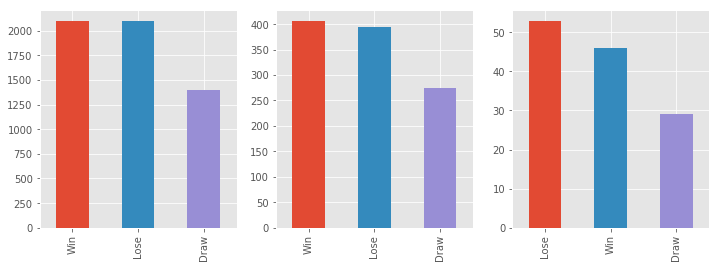

In [10]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

,elo_diff,rating_diff,potential_diff,height_diff,weight_diff,age_diff,weak_foot_diff,internationl_repuatiotion_diff,crossing_diff,finishing_diff,...,standing_tackle_diff,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
elo_diff,1.000000,0.768813,0.764831,0.527095,0.428870,0.442228,0.454825,0.717111,0.691644,0.677136,...,0.590452,-0.501759,-0.479211,0.378885,0.526378,0.469651,0.477961,0.472272,0.488763,0.474484
rating_diff,0.768813,1.000000,0.972781,0.746874,0.629623,0.667844,0.566764,0.772075,0.763730,0.759369,...,0.720767,-0.385608,-0.424872,0.349531,0.409187,0.428284,0.534826,0.530694,0.526265,0.533353
potential_diff,0.764831,0.972781,1.000000,0.758617,0.624043,0.566723,0.560022,0.756928,0.761666,0.752592,...,0.720662,-0.374469,-0.422394,0.353006,0.410131,0.433405,0.541147,0.535973,0.527696,0.538922
height_diff,0.527095,0.746874,0.758617,1.000000,0.895712,0.663877,0.495213,0.474242,0.606831,0.631011,...,0.662481,-0.240286,-0.320327,0.215733,0.281510,0.306660,0.593022,0.583162,0.546409,0.587675
weight_diff,0.428870,0.629623,0.624043,0.895712,1.000000,0.602154,0.369116,0.397107,0.445947,0.511126,...,0.563143,-0.199945,-0.265488,0.162245,0.229658,0.241567,0.516220,0.506793,0.465849,0.507726
age_diff,0.442228,0.667844,0.566723,0.663877,0.602154,1.000000,0.447162,0.457709,0.541781,0.533568,...,0.564285,-0.223947,-0.267849,0.176780,0.206163,0.234873,0.466401,0.459851,0.445259,0.464564
weak_foot_diff,0.454825,0.566764,0.560022,0.495213,0.369116,0.447162,1.000000,0.401255,0.567310,0.549486,...,0.468918,-0.256563,-0.257400,0.186870,0.277020,0.247890,0.279466,0.271528,0.283723,0.275077
internationl_repuatiotion_diff,0.717111,0.772075,0.756928,0.474242,0.397107,0.457709,0.401255,1.000000,0.583759,0.577949,...,0.543591,-0.391124,-0.381102,0.375875,0.405395,0.398289,0.433043,0.427105,0.404894,0.427255
crossing_diff,0.691644,0.763730,0.761666,0.606831,0.445947,0.541781,0.567310,0.583759,1.000000,0.875160,...,0.787130,-0.331194,-0.389622,0.302824,0.366922,0.404654,0.458791,0.451312,0.496571,0.460128
finishing_diff,0.677136,0.759369,0.752592,0.631011,0.511126,0.533568,0.549486,0.577949,0.875160,1.000000,...,0.664598,-0.331592,-0.388761,0.289237,0.355251,0.395295,0.451931,0.445093,0.475757,0.454903


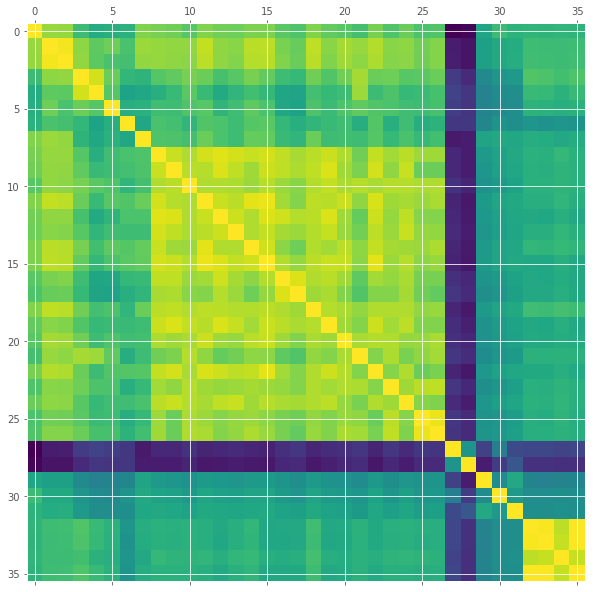

In [11]:
plt.figure(figsize=(10,10))
plt.matshow(X_train.corr(), fignum=1)
X_train.corr()

In [12]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [13]:
def get_feature_importance(clf):
    zipped = sorted(zip(feature_columns, clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [14]:
def run_random_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      n_iter_search=60, custom_report_for_model=None):
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)
    return best_clf

In [23]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

param_dist = {"n_estimators": [1000],
              "max_depth": [None],
              "min_samples_leaf": [5],
              "max_features": ["sqrt"],
              "criterion": ["gini"]}
best_clf = run_random_search(clf, param_dist,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance, 
                             n_iter_search=1)

TRAIN SET METRICS:
SCORE:  0.913586859489
             precision    recall  f1-score   support

       -1.0       0.90      0.93      0.92      2096
        0.0       0.99      0.84      0.91      1402
        1.0       0.89      0.94      0.91      2103

avg / total       0.92      0.91      0.91      5601

BEST PARAMS:  {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


TEST SET METRICS:
SCORE:  0.532093023256

              precision    recall  f1-score   support

       -1.0       0.52      0.72      0.60       394
        0.0       0.28      0.04      0.07       274
        1.0       0.56      0.69      0.62       407

avg / total       0.48      0.53      0.47      1075



WC SET METRICS:
SCORE:  0.5703125

              precision    recall  f1-score   support

       -1.0       0.60      0.68      0.64        53
        0.0       0.50      0.03      0.06        29
        1.0       0.55      0.78      0.64        46

a

In [21]:
def get_better_team(first_team, second_team):
    if first_team["points"] > second_team["points"]:
        return -1
    elif first_team["points"] < second_team["points"]:
        return 1
    
    if first_team["goal_diff"] > second_team["goal_diff"]:
        return -1
    elif first_team["goal_diff"] < second_team["goal_diff"]:
        return 1
    
    if first_team["goals_scored"] > second_team["goals_scored"]:
        return -1
    elif first_team["goals_scored"] < second_team["goals_scored"]:
        return 1
    
    f_name = first_team["Team"]
    s_name = second_team["Team"]
    if (first_team[f"{f_name}-{s_name}"] > 0):
        return -1
    elif (first_team[f"{f_name}-{s_name}"] < 0):
        return 1
    else:
        return - 1 if random.random() > 0.5 else -1

def sort_groups(table):
    next_round = pd.DataFrame()
    for group in np.unique(table["Group"]):
        group_df = table[table["Group"] == group]
        teams = [group_df.iloc[0], group_df.iloc[1], group_df.iloc[2], group_df.iloc[3]]
        shorted_standing = sorted(teams, key=functools.cmp_to_key(get_better_team))
        tmp = pd.concat([row.to_frame().T for row in shorted_standing])
        next_round = pd.concat([next_round, tmp])[["Team", "points", "Group"]]
    return next_round

def predict_match_outcome(match):
    data = get_match_feature_vector(match)
    data["home_win"] = np.sign(data["home_score"] - data["away_score"])

    x = calculate_relative_features(data)
    x = x[feature_columns]
    match_sign = best_clf.predict(x)
    probas = best_clf.predict_proba(x)
    
    data["home_score"] = 0
    data["away_score"] = 0
    data["tournament"] = "FIFA World Cup"
    data["year"] = 2018
    post_match_results(data)
    
    return match_sign, probas

def print_group_standings(table):
    columns = ['Position', 'Group A', 'Points A', 'Group B', 'Points B', 'Group C', 'Points C', 
               'Group D', 'Points D', 'Group E', 'Points E', 'Group F', 'Points F', 
               'Group G', 'Points G', 'Group H', 'Points H']

    data = {"Position": [1,2,3,4]}
    df = pd.DataFrame(data, columns = columns)

    for idx, group in enumerate(["A", "B", "C", "D", "E", "F", "G", "H"]):
        group_df = table[table["Group"] == group]
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index', 'Group'], axis=1)
        df.iloc[:, 1 + (idx * 2)] = group_df["Team"]
        df.iloc[:, 2 + (idx * 2)] = group_df["points"]

    print("\n\n", df)

In [24]:
group_table = pd.read_csv('data/original/world_cup_2018_dataset.csv')
group_table = group_table[["Team", "Group"]]
group_table['points'] = 0
group_table['goal_diff'] = 0
group_table['goals_scored'] = 0

wc_2018_matches = pd.read_csv('data/original/wc_2018_games.csv')

print("\n\n\n___Group Stage___\n")
for index, match in wc_2018_matches.iloc[0:48].iterrows():
    match = match.to_dict()
    match["home_win"] = np.sign(match["home_score"] - match["away_score"])
    match_sign, probas = predict_match_outcome(match)
    
    if match_sign != match["home_win"]:
        print(f"\x1b[31m{match['home_team']} - {match['away_team']}: \x1b[0m", end='')
    else:
        print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
        
    if match_sign == 1:
        group_table.loc[group_table["Team"] == match["home_team"], "points"] += 3
    elif match_sign == 0:
        group_table.loc[group_table["Team"] == match["home_team"], "points"] += 1
        group_table.loc[group_table["Team"] == match["away_team"], "points"] += 1
    elif match_sign == -1:
        group_table.loc[group_table["Team"] == match["away_team"], "points"] += 3
        
    home = match["home_team"]
    away = match["away_team"]
    group_table[f"{home}-{away}"] = match["home_score"] - match["away_score"]
    group_table[f"{away}-{home}"] = match["away_score"] - match["home_score"]
    
group_table = sort_groups(group_table)
print_group_standings(group_table)

i = 0
print("\n\n\n___Round of 16___\n")
for index, match in wc_2018_matches.iloc[48:56].iterrows():
    home_group, home_position = list(match["home_team"])
    away_group, away_position = list(match["away_team"])

    wc_2018_matches.loc[index, "home_team"] = group_table[group_table["Group"] == home_group].iloc[int(home_position)-1]["Team"]
    wc_2018_matches.loc[index, "away_team"] = group_table[group_table["Group"] == away_group].iloc[int(away_position)-1]["Team"]
    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
    team_col = "home_team" if index%2 == 0 else "away_team" 
    
    if match_sign == 1:
        wc_2018_matches.loc[56 + i, team_col] = match["home_team"]
    else:
        wc_2018_matches.loc[56 + i, team_col] = match["away_team"]
        
    if index%2 != 0:
        i += 1
    
i = 0
print("\n\n\n___Quarter-Finals___\n")
for index, match in wc_2018_matches.iloc[56:60].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
    team_col = "home_team" if index%2 == 0 else "away_team" 
    if match_sign == 1:
        wc_2018_matches.loc[60 + i, team_col] = match["home_team"]
    else:
        wc_2018_matches.loc[60 + i, team_col] = match["away_team"]
        
    if index%2 != 0:
        i += 1
        
print("\n\n\n___Semi-Finals___\n")
for index, match in wc_2018_matches.iloc[60:62].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    team_col = "home_team" if index%2 == 0 else "away_team" 
    
    if match_sign == 1:
        wc_2018_matches.loc[63, team_col] = match["home_team"]
        wc_2018_matches.loc[62, team_col] = match["away_team"]
    else:
        wc_2018_matches.loc[63, team_col] = match["away_team"]
        wc_2018_matches.loc[62, team_col] = match["home_team"]
        

print("\n\n\n___Third place play-off___\n")
for index, match in wc_2018_matches.iloc[62:63].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
print("\n\n\n___Final___\n")
for index, match in wc_2018_matches.iloc[63:].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
post_simulation()




___Group Stage___

Russia - Saudi Arabia: 1.0 -- PROBAS -- [[ 0.23283797  0.3054879   0.46167412]]
Egypt - Uruguay: -1.0 -- PROBAS -- [[ 0.51741108  0.31207437  0.17051455]]
Morocco - IR Iran: -1.0 -- PROBAS -- [[ 0.38997448  0.223237    0.38678851]]
Portugal - Spain: -1.0 -- PROBAS -- [[ 0.37004871  0.3230674   0.30688388]]
France - Australia: 1.0 -- PROBAS -- [[ 0.12332158  0.21703141  0.65964701]]
Argentina - Iceland: 1.0 -- PROBAS -- [[ 0.15101694  0.17320056  0.6757825 ]]
Peru - Denmark: 1.0 -- PROBAS -- [[ 0.31213475  0.29222505  0.39564021]]
Croatia - Nigeria: 1.0 -- PROBAS -- [[ 0.1733598   0.25314241  0.57349779]]
Costa Rica - Serbia: -1.0 -- PROBAS -- [[ 0.39118699  0.33138355  0.27742946]]
Germany - Mexico: 1.0 -- PROBAS -- [[ 0.1330995   0.21035929  0.65654121]]
Brazil - Switzerland: 1.0 -- PROBAS -- [[ 0.16416856  0.23520889  0.60062255]]
Sweden - Korea Republic: 1.0 -- PROBAS -- [[ 0.30364396  0.25338308  0.44297296]]
Belgium - Panama: 1.0 -- PROBAS -- [[ 0.04492808  0